Other links:
1. [ISS Longeron Datasets](https://www.topcoder.com/thrive/articles/ISS%20Longeron%20-%20Datasets)
2. [Spectrolab XTJ Datasheet](https://www.spectrolab.com/photovoltaics/XTJ-Prime_Data_Sheet.pdf)

In [2]:
import csv
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from shapely.geometry import Polygon
from solarcell import solarcell

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Roll-out deployment ✅<br><br>The sixth IROSA wing, developed in partnership with <a href="https://twitter.com/BoeingSpace?ref_src=twsrc%5Etfw">@BoeingSpace</a> + <a href="https://twitter.com/Spectrolab_Inc?ref_src=twsrc%5Etfw">@Spectrolab_Inc</a>, has completed deployment on <a href="https://twitter.com/Space_Station?ref_src=twsrc%5Etfw">@Space_Station</a>! <a href="https://t.co/rWgdYCYsGn">https://t.co/rWgdYCYsGn</a></p>&mdash; Redwire Space (@RedwireSpace) <a href="https://twitter.com/RedwireSpace/status/1669391470191865856?ref_src=twsrc%5Etfw">June 15, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

https://redwirespace.com/newsroom/redwires-roll-out-solar-array-technology-successfully-installed/

77


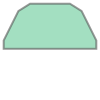

In [3]:
# compute the cell area of the iROSA Spectrolab XTJ cells
vertices = [
    (0.00, 0.00),
    (0.00, 1.25),
    (2.20, 5.65),
    (3.95, 6.75),
    (9.90, 6.75),
    (11.65, 5.65),
    (13.85, 1.25),
    (13.85, 0),
]  # vertices extracted from the datasheet picture!
polygon = Polygon(vertices)
print(area := int(polygon.area))
polygon

In [4]:
solarcell.rss = 0.07

spectrolab_xtj = solarcell(
    isc=(0.018 * area, 10e-6 * area),
    voc=(2.72, -0.0056),
    imp=(0.0175 * area, 5e-6 * area),
    vmp=(2.406, -0.0063),
    t=28,
)  # parameters taken from the datasheet

In [5]:
ntot = 8 * 6 * 32 * 6  # total number of cells per iROSA
nseries = 8 * 12  # number of cells in series per string
assert not ntot % nseries  # check nseries divides ntot
size = (nseries, int(ntot / nseries))
size

(96, 96)

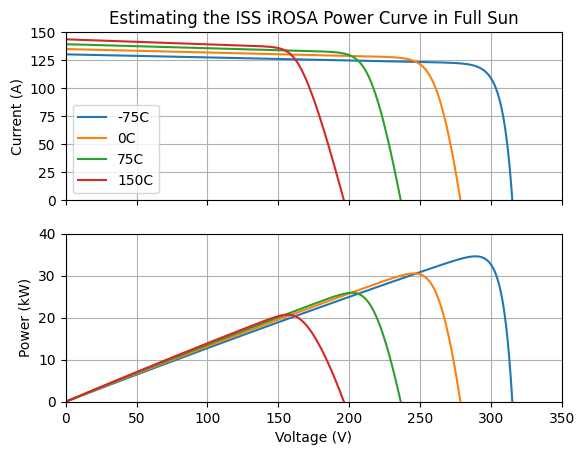

In [6]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

for temp in np.linspace(-75, 150, 4):
    t = np.full(size, temp)
    g = np.full(size, 1)
    array = spectrolab_xtj.array(t, g)
    v = np.linspace(0, array.voc, 1000)
    ax0.plot(v, array.iv(v), label="{:0.0f}C".format(temp))
    ax1.plot(v, array.pv(v) / 1000)

ax0.set_xlim([0, 350]), ax1.set_xlabel("Voltage (V)")
ax0.set_ylim([0, 150]), ax0.set_ylabel("Current (A)")
ax1.set_ylim([0, 40]), ax1.set_ylabel("Power (kW)")
ax0.set_title("Estimating the ISS iROSA Power Curve in Full Sun")
ax0.grid(), ax1.grid()
_ = ax0.legend()

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Check out the new view on <a href="https://twitter.com/Space_Station?ref_src=twsrc%5Etfw">@Space_Station</a>!<a href="https://twitter.com/hashtag/ICYMI?src=hash&amp;ref_src=twsrc%5Etfw">#ICYMI</a>: The first of our iROSA solar arrays was successfully installed on space station at 11:24am ET this morning. At 63 feet long and 20 feet wide, they&#39;ll provide a significant power boost 🔋 to the orbiting laboratory! (📸: <a href="https://twitter.com/NASA?ref_src=twsrc%5Etfw">@NASA</a>) <a href="https://t.co/IFDAs8Az2G">pic.twitter.com/IFDAs8Az2G</a></p>&mdash; Redwire Space (@RedwireSpace) <a href="https://twitter.com/RedwireSpace/status/1406680770782109697?ref_src=twsrc%5Etfw">June 20, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [7]:
def csvread(filename):
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        return np.array([tuple(map(float, row)) for row in reader])

In [8]:
calXIDX = [0, 0, 5, 5, 12, 12, 17, 17]
calYIDX = [0, 0, 7, 7, 248, 248, 255, 255]
calL = csvread(filename="irosa_shading_data/Calibration-L.csv")
calR = csvread(filename="irosa_shading_data/Calibration-R.csv")
sunL = csvread(filename="irosa_shading_data/Sunlight-L.csv")
sunR = csvread(filename="irosa_shading_data/Sunlight-R.csv")

In [9]:
def calfit(idx, pos, nc):
    # Given idx/pos calibration data, return a function idx = FUNC(pos)
    # by using numerical optimization methods.

    def idx2pos(idx, nc, dc, dg):
        # Convert the cell index to cell position.
        #     idx: index of the cell position
        #     nc: number of cells per group
        #     dc: distance between cells within a group
        #     dg: distance between cells between groups

        ng = np.floor(idx / nc)
        return ng * dg + (idx - ng) * dc

    def fiterr(x):
        return np.vectorize(lambda i: idx2pos(i, nc, *x))(idx) - pos

    result = least_squares(fun=fiterr, x0=(1, 1))
    assert result.success

    def pos2idx(pos):
        ret = least_squares(fun=lambda i: idx2pos(i, nc, *result.x) - pos, x0=pos)
        assert ret.success
        return int(np.round(ret.x)[0])

    return pos2idx

In [10]:
def sunidx(cal, sun, ncx, ncy):
    pos2idx_X = calfit(calXIDX, np.sort(cal[:, 0]), ncx)
    pos2idx_Y = calfit(calYIDX, np.sort(cal[:, 1]), ncy)
    idx = [(pos2idx_X(x), pos2idx_Y(y)) for x, y in sun]
    idx = list(sorted(idx))

    ret = defaultdict(list)
    for x, y in idx:
        ret[x].append(y)

    return ret

In [11]:
def sunmap(cal, sun, ncx, ncy, nx, ny):
    idx = sunidx(cal, sun, ncx, ncy)
    sunlight = np.full((nx, ny), False)  # intialize to shaded

    for x in range(sunlight.shape[0]):
        sun = True
        for y1, y2 in zip(idx[x], idx[x][1:]):
            sunlight[x, y1 : y2 + 1] = sun
            sun = not sun

    return np.flip(sunlight)

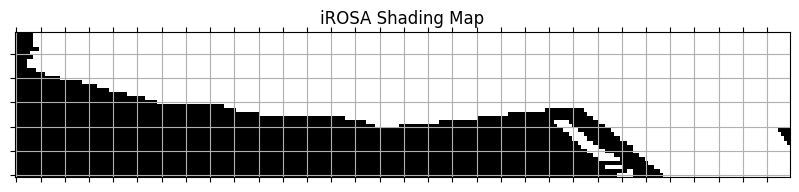

In [12]:
sunmapL = sunmap(calL, sunL, 6, 8, 18, 256)
sunmapR = sunmap(calR, sunR, 6, 8, 18, 256)
sunmapLR = np.vstack([sunmapR, sunmapL])

plt.figure(figsize=(10, 10))
plt.spy(np.invert(sunmapLR), origin="lower", aspect=8 / 6)
plt.xticks(range(0, 256, 8), labels=[])
plt.yticks(range(0, 36, 6), labels=[])
plt.title("iROSA Shading Map")
plt.grid()

In [13]:
shaded_per_string = []

for xs in range(6):
    for ys in range(16):
        string = sunmapLR[xs * 6 : (xs + 1) * 6, ys * 16 : (ys + 1) * 16]
        shaded_per_string.append(np.invert(string).sum())

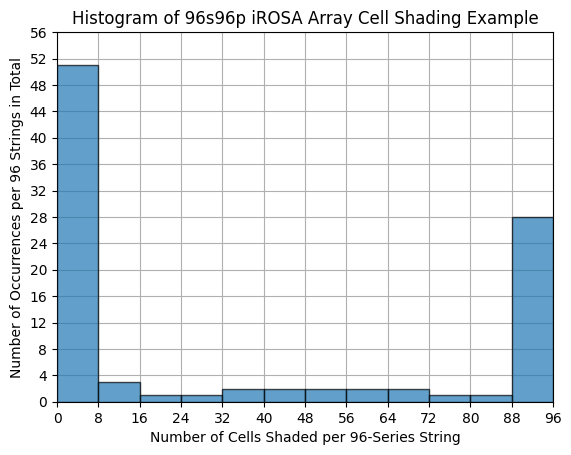

In [14]:
plt.hist(shaded_per_string, bins=12, alpha=0.7, edgecolor="black", zorder=3)
plt.xticks(range(0, 96 + 8, 8))
plt.yticks(range(0, 56 + 4, 4))
plt.xlim((0, nseries))
plt.ylim((0, 56))
plt.grid(zorder=0)
plt.xlabel("Number of Cells Shaded per 96-Series String")
plt.ylabel("Number of Occurrences per 96 Strings in Total")
_ = plt.title("Histogram of 96s96p iROSA Array Cell Shading Example")

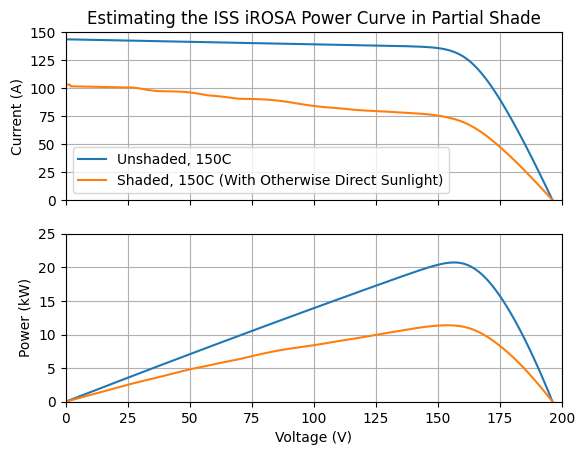

In [15]:
g_unshaded = np.full(size, 1)
g_shaded = np.full(size, 1)
for i, k in enumerate(shaded_per_string):
    g_shaded[0:k, i] = 0

t = np.full(size, 150)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

array_unshaded = spectrolab_xtj.array(t, g_unshaded)
v = np.linspace(0, array_unshaded.voc, 1000)
ax0.plot(v, array_unshaded.iv(v), label="Unshaded, 150C")
ax1.plot(v, array_unshaded.pv(v) / 1000)

array_shaded = spectrolab_xtj.array(t, g_shaded)
v = np.linspace(0, array_shaded.voc, 1000)
ax0.plot(v, array_shaded.iv(v), label="Shaded, 150C (With Otherwise Direct Sunlight)")
ax1.plot(v, array_shaded.pv(v) / 1000)

ax0.set_xlim([0, 200]), ax1.set_xlabel("Voltage (V)")
ax0.set_ylim([0, 150]), ax0.set_ylabel("Current (A)")
ax1.set_ylim([0, 25]), ax1.set_ylabel("Power (kW)")
ax0.set_title("Estimating the ISS iROSA Power Curve in Partial Shade")
ax0.grid(), ax1.grid()
_ = ax0.legend()

In [16]:
# Fraction of the solar array that is shaded: 62.4%
sunmapLR.sum() / sunmapLR.size

0.6243489583333334

In [17]:
# Fraction of output power due to shading: 55.0%
array_shaded.pmp / array_unshaded.pmp

0.5489754357114139

**Conclusion: By computing the actual shaded IV curve, it's clear that the resulting power is actually significantly less compared to an estimate based on simply the fraction of the array that is shaded. We can compute the poewr difference at different temperatures... in this case at 150C the difference is -7.4%.**

In [18]:
for temp in np.linspace(-75, 150, 4):
    t = np.full(size, temp)
    array_unshaded = spectrolab_xtj.array(t, g_unshaded)
    array_shaded = spectrolab_xtj.array(t, g_shaded)
    power_fraction = array_shaded.pmp / array_unshaded.pmp
    shade_fraction = sunmapLR.sum() / sunmapLR.size
    print(temp, power_fraction, power_fraction - shade_fraction)

-75.0 0.5300604984482975 -0.09428845988503587
0.0 0.5352169049449135 -0.0891320533884199
75.0 0.540621429261957 -0.08372752907137637
150.0 0.5489754357114139 -0.07537352262191943
